# SSN Rynek Dnia Następnego - predykcja szeregów czasowych

Imię i nazwisko: Marcin Bobiński

### Zbiór danych

Celem jest predykcja ceny energii elektrycznej na polskim Rynku Dnia Następnego (kontrakty zawierane na kolejny dzień) na 24h do przodu

* fixing  - szukana cena [zł/MWh]
* fixing_1_volume - obrót w danej godzinie [MWh]
* hour - godzina
* date - data

Pozostałe wg danych PSE https://www.pse.pl/dane-systemowe/plany-pracy-kse/biezacy-plan-koordynacyjny-dobowy-bpkd/wielkosci-podstawowe
* JWCD - jednostki wytwórcze centralnie dysponowane
* nJWCD - pozostałe (w tym np energia wiatrowa)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Wczytujemy i wyświetlamy zbiór danych

In [2]:
df = pd.read_csv('rdn_data_lab5.csv', sep=';')
df

,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie
0,70.50,2582.7,0,2017-12-25,14250,22290,11171,4067,10183,5053,1285
1,70.03,2672.5,1,2017-12-25,13450,22290,11087,3353,10097,4972,1213
2,70.03,2439.4,2,2017-12-25,12913,22290,10963,2945,9968,4852,1164
3,70.03,2370.0,3,2017-12-25,12575,22290,10846,2724,9851,4736,1134
4,70.03,2378.7,4,2017-12-25,12475,22290,10687,2785,9690,4582,1125
...,...,...,...,...,...,...,...,...,...,...,...
11422,190.49,3016.6,22,2019-04-14,17425,21284,7938,10330,7095,2191,1563
11423,172.40,2843.3,23,2019-04-14,16300,21284,7775,9363,6937,2035,1462
11424,195.26,2673.0,0,2019-04-15,15188,21743,7562,8412,6776,1809,1362
11425,196.82,2790.9,1,2019-04-15,14675,21803,7382,8080,6595,1660,1315


In [3]:
# formatowanie dat
df['date_hour'] = df['date'] + ' ' + df['hour'].astype(str).str.pad(width=2, fillchar='0')
df['date_hour'] = pd.to_datetime(df['date_hour'], format="%Y-%m-%d %H")
df.set_index('date_hour', inplace=True)

### Silna zależność od godziny i dnia tygodnia

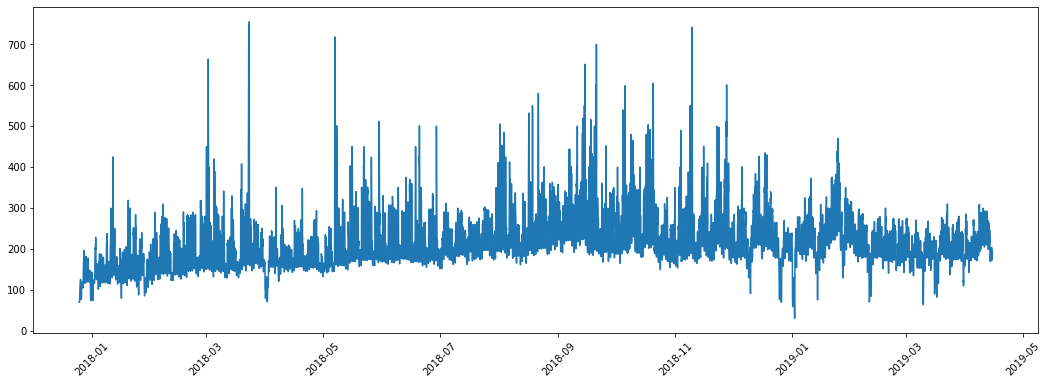

In [4]:
plt.figure(figsize=(18,6))
plt.plot(df['fixing'])
plt.xticks(rotation=45);
plt.show()

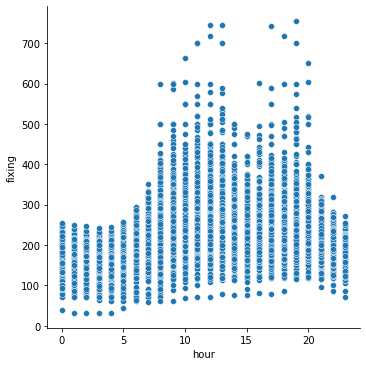

In [5]:
sns.relplot(data=df, x='hour', y='fixing')

### DODANIE DNIA MIESIĘCA I ROKU W POSTACI LICZBOWEJ

In [6]:
def fday(date):
    return int(date.split("-")[2])
def fmonth(date):
    return int(date.split("-")[1])
def fyear(date):
    return int(date.split("-")[0])


df['day'] = df['date'].apply(fday)
df['month'] = df['date'].apply(fmonth)
df['year'] = df['date'].apply(fyear)

### Opóźnienie danych wyjściowych

In [7]:
#dane przesunięte o 24h 
df['fixing_minus_24h'] = df['fixing'].shift(24)
df['Krajowe zapotrzebowanie na moc_minus_24h'] = df['Krajowe zapotrzebowanie na moc'].shift(24)
df['Suma zdolności wytwórczych JWCD_minus_24h'] = df['Suma zdolności wytwórczych JWCD'].shift(24)
df['Suma zdolności wytwórczych nJWCD_minus_24h'] = df['Suma zdolności wytwórczych nJWCD'].shift(24)
df['Generacja JWCD_minus_24h'] = df['Generacja JWCD'].shift(24)
df['Generacja nJWCD_minus_24h'] = df['Generacja nJWCD'].shift(24)
df['Generacja źródeł wiatrowych_minus_24h'] = df['Generacja źródeł wiatrowych'].shift(24)
df['Wymagana rezerwa mocy ponad zapotrzebowanie_minus_24h'] = df['Wymagana rezerwa mocy ponad zapotrzebowanie'].shift(24)

#dane dane przesunięte o 7 dni
df['fixing_minus_7d'] = df['fixing'].shift(24 * 7)
df['Krajowe zapotrzebowanie na moc_minus_7d'] = df['Krajowe zapotrzebowanie na moc'].shift(24 * 7)
df['Suma zdolności wytwórczych JWCD_minus_7d'] = df['Suma zdolności wytwórczych JWCD'].shift(24 * 7)
df['Suma zdolności wytwórczych nJWCD_minus_7d'] = df['Suma zdolności wytwórczych nJWCD'].shift(24 * 7)
df['Generacja JWCD_minus_7d'] = df['Generacja JWCD'].shift(24 * 7)
df['Generacja nJWCD_minus_7d'] = df['Generacja nJWCD'].shift(24 * 7)
df['Generacja źródeł wiatrowych_minus_7d'] = df['Generacja źródeł wiatrowych'].shift(24 * 7)
df['Wymagana rezerwa mocy ponad zapotrzebowanie_minus_7d'] = df['Wymagana rezerwa mocy ponad zapotrzebowanie'].shift(24 * 7)


In [8]:
# usunięcie braków danych spowodowanych przesuwaniem
df.dropna(inplace=True)

### Podział na zbiór uczący i testowy

In [9]:
df_train = df[df.index < '01-01-2019'] 
df_test = df[df.index >= '01-01-2019'] 
print(len(df_train))
print(len(df_test))

8760
2499


In [10]:
# lista kolumn, które będą danymi wejściowymi
cols = []

#aktywacje
cols.append('hour')
cols.append('day')
cols.append('month')
cols.append('year') #mała zmienność 
cols.append('Krajowe zapotrzebowanie na moc')
cols.append('Suma zdolności wytwórczych JWCD')
cols.append('Suma zdolności wytwórczych nJWCD')
cols.append('Generacja JWCD')
cols.append('Generacja nJWCD')
cols.append('Generacja źródeł wiatrowych')
cols.append('Wymagana rezerwa mocy ponad zapotrzebowanie')

#aktywacje sprzed 24h
cols.append('fixing_minus_24h')
cols.append('Krajowe zapotrzebowanie na moc_minus_24h')
cols.append('Suma zdolności wytwórczych JWCD_minus_24h')
cols.append('Suma zdolności wytwórczych nJWCD_minus_24h')
cols.append('Generacja JWCD_minus_24h')
cols.append('Generacja nJWCD_minus_24h')
cols.append('Generacja źródeł wiatrowych_minus_24h')
cols.append('Wymagana rezerwa mocy ponad zapotrzebowanie_minus_24h')

#aktywacje sprzed 7d
cols.append('fixing_minus_7d')
cols.append('Krajowe zapotrzebowanie na moc_minus_7d')
cols.append('Suma zdolności wytwórczych JWCD_minus_7d')
cols.append('Suma zdolności wytwórczych nJWCD_minus_7d')
cols.append('Generacja JWCD_minus_7d')
cols.append('Generacja nJWCD_minus_7d')
cols.append('Generacja źródeł wiatrowych_minus_7d')
cols.append('Wymagana rezerwa mocy ponad zapotrzebowanie_minus_7d')


In [11]:
y_train = df_train['fixing']
X_train = df_train[cols]
y_test = df_test['fixing']
X_test = df_test[cols]


### Sieć neuronowa

In [12]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(256, input_shape=(X_train.tail(1).shape[1],)))
model.add(tf.keras.layers.Dense((128)))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])

In [13]:
# epochs - liczba przejść przez cały zbiór uczący
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
274/274 [==============================] - 0s 1ms/step - loss: 3671022.7500 - mean_absolute_error: 644.5156
Epoch 2/100
274/274 [==============================] - 0s 1ms/step - loss: 7611.6289 - mean_absolute_error: 66.2959
Epoch 3/100
274/274 [==============================] - 0s 1ms/step - loss: 3947.2393 - mean_absolute_error: 46.5955
Epoch 4/100
274/274 [==============================] - 0s 1ms/step - loss: 2979.8008 - mean_absolute_error: 39.6159
Epoch 5/100
274/274 [==============================] - 0s 1ms/step - loss: 3196.0093 - mean_absolute_error: 41.3171
Epoch 6/100
274/274 [==============================] - 0s 1ms/step - loss: 3275.2639 - mean_absolute_error: 42.5645
Epoch 7/100
274/274 [==============================] - 0s 1ms/step - loss: 4476.6865 - mean_absolute_error: 51.1172
Epoch 8/100
274/274 [==============================] - 0s 1ms/step - loss: 3746.3159 - mean_absolute_error: 45.5839
Epoch 9/100
274/274 [==============================] - 0s 1ms/step -

In [14]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 855us/step - loss: 489.5797 - mean_absolute_error: 17.3365


[489.5796813964844, 17.33648109436035]

In [15]:
y_hat = model.predict(X_test)
y_hat

array([[135.44629],
       [117.75106],
       [ 97.64413],
       ...,
       [150.5587 ],
       [147.9102 ],
       [146.60927]], dtype=float32)

### Wykres przewidzianych i prawdziwych wartości

In [16]:
df_plot = pd.DataFrame(y_test)
df_plot['y_hat'] = y_hat

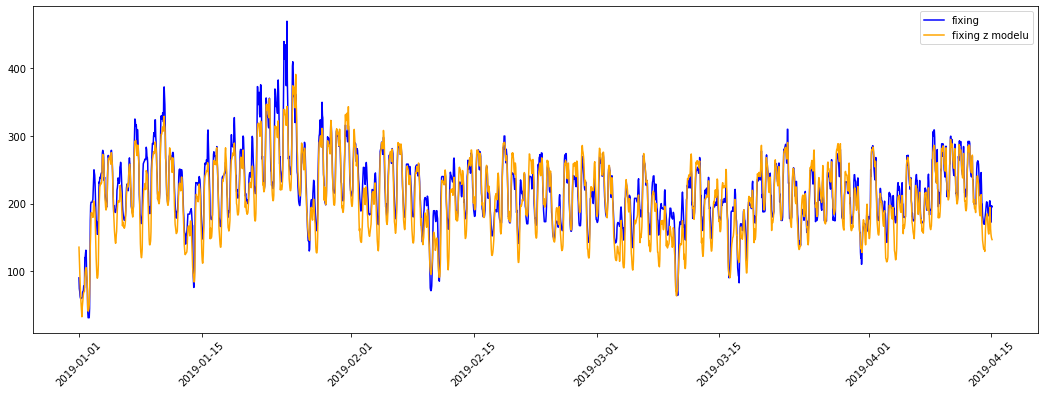

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(df_plot['fixing'], 'blue')
plt.plot(df_plot['y_hat'], 'orange')
plt.xticks(rotation=45);
plt.legend(['fixing', 'fixing z modelu'])